## GAN on MNIST

https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter4-gan/dcgan-mnist-4.2.1.py

https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

https://github.com/keras-team/keras/issues/8585

https://github.com/soumith/ganhacks

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import keras
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, Input
from keras.layers import Dense, BatchNormalization, Activation, LeakyReLU, Dropout, \
                                Reshape, UpSampling2D, Conv2DTranspose, Flatten, Conv2D
from keras.optimizers import RMSprop, Adam, SGD
from keras.datasets import mnist, fashion_mnist
from keras.engine.network import Network
from keras.callbacks import TensorBoard
import keras.backend as K

from tqdm import tqdm_notebook
from collections import namedtuple

%matplotlib inline

In [4]:
K.image_data_format(), K.backend()

('channels_last', 'tensorflow')

In [5]:
# K.tensorflow_backend._get_available_gpus()

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [8]:
X_train = np.vstack((X_train, X_test))
y_train = np.hstack((y_train, y_test))

In [9]:
X_train = X_train[y_train==3]

In [40]:
X = np.load('C:\\Users\\adamm\\Downloads\\full_numpy_bitmap_sun.npy')
X.resize(149736, 28, 28)
X_train = X

In [41]:
def add_lr_flips(x):
    flip_lr = np.flip(x, axis=2)
    return np.vstack((x, flip_lr))

X_train = add_lr_flips(X_train)

In [42]:
X_train.shape

(299472, 28, 28)

In [43]:
def scale(a):
    """-1 to 1 for tanh"""
    return (2 * (a - a.min()) / (a.max() - a.min())) - 1

def reverse_scale(a):
    return 255 * (a - a.min()) / (a.max() - a.min())
    
X_train = scale(X_train)

In [45]:
batch_size = 512
n_batches = int(X_train.shape[0] / batch_size)
n_batches

584

In [46]:
def make_generator():
    depth = 64 + 64 + 64 + 64
    dim = 7
    units = dim * dim * depth

    model = Sequential([
        Dense(input_dim=100, units=units),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.2),
        Reshape((dim, dim, depth)),
        UpSampling2D(),
        Conv2DTranspose(int(depth/2), 5, padding='same'),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(int(depth/4), 5, padding='same'),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.2),
        UpSampling2D(),
        Conv2DTranspose(int(depth/8), 5, padding='same'),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, 5, padding='same'),
        Activation('tanh'),
    ])

    noise = Input(shape=(100,))
    image = model(noise)
    return Model(noise, image)
    

make_generator().summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         2394241   
Total params: 2,394,241
Trainable params: 2,368,705
Non-trainable params: 25,536
_________________________________________________________________


In [47]:
def make_discriminator():
    depth = 64
    dropout = 0.9
    input_shape = (28, 28, 1)

    model = Sequential([
        Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(dropout),
        Conv2D(depth*2, 5, strides=2, input_shape=input_shape, padding='same'),
        LeakyReLU(alpha=0.2),       
        Dropout(dropout),        
        Flatten(),
        Dense(1),
#         Activation('sigmoid'),
    ])
        
    image = Input(shape=(28, 28, 1))
    guess = model(image)
    return Model(image, guess)


In [79]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def make_models():
    generator = make_generator()
    discriminator = make_discriminator()

#     generator.compile(
#         loss='binary_crossentropy',
#         optimizer=Adam(lr=0.00004, clipvalue=0.01, decay=3e-8),
#         metrics=['accuracy'],
#     )
    discriminator.compile(
        loss=wasserstein_loss,
#         optimizer=Adam(lr=0.00005, clipvalue=0.01, decay=6e-8),
        optimizer=RMSprop(lr=0.00005),
        metrics=['accuracy'],
    )
    
    discriminator.trainable = False
    noise = Input(shape=(100,))
    adversarial = Model(noise, discriminator(generator(noise)))
    adversarial.compile(
        loss=wasserstein_loss,
        optimizer=Adam(lr=0.00005, clipvalue=0.01, decay=6e-8),
        metrics=['accuracy'],
    )
    Models = namedtuple('Models', 'g d a')
    return Models(g=generator, d=discriminator, a=adversarial)


In [80]:
class GAN:
    
    n_save = 5
    
    def __init__(self):
        self.models = make_models()
        self.epochs = 0
        
    def make_noise(self):
        return np.random.uniform(-1, 1, size=(batch_size, 100))

    def predict_from_noise(self):
        return self.models.g.predict(self.make_noise())
    
    def ones_batch(self):
        return np.ones((batch_size, 1))
    
    def zeros_batch(self):
        return np.zeros((batch_size, 1))
            
    def train(self, X):
        X = X.copy()
        np.random.shuffle(X)
        X = X.reshape(*X.shape, 1)
        d_loss = 0
        x0 = 0
        x1 = batch_size
        pbar = tqdm_notebook(range(n_batches), leave=False)
        for i in pbar:
            # train d fake
            noise = self.make_noise()
            fake = self.models.g.predict(noise)
            zeros = self.zeros_batch()
            d_loss_fake, acc_f = self.models.d.train_on_batch(fake, zeros)
            # train d real
            real = X[x0:x1, :, :].reshape(batch_size, 28, 28, 1)
            ones = self.ones_batch()
            d_loss_real, acc_r = self.models.d.train_on_batch(real, ones)
            d_loss += np.log(0.5*(d_loss_fake + d_loss_real))
            # train adversarial
            noise = self.make_noise()
            ones = self.ones_batch()
            a_loss, acc_a = self.models.a.train_on_batch(noise, ones)
            pbar.set_description(' {} F:{:.2f} R:{:.2f} | A:{:.2f}'.format(self.epochs, d_loss_fake, d_loss_real, a_loss))
            # update batch indices
            x0 += batch_size
            x1 += batch_size
        
#         image = fake[0:1, :, :, :]
#         summary = tf.summary.image('sample', tf.convert_to_tensor(image), family='samples')
#         self.writer.add_summary(summary, self.epochs)
        
        self.epochs += 1
        
    def show(self, shape=(4, 4)):
        rows, cols = shape
        yhat = self.predict_from_noise()
        np.random.shuffle(yhat)
        yhat = reverse_scale(yhat)
        fig, axes_groups = plt.subplots(rows, cols, figsize=(2*rows, 2*cols), sharex=True, sharey=True)
        count = 0
        for i, axes in enumerate(axes_groups):
            for j, ax in enumerate(axes):
                img = yhat[count, :, :, :]
                img = img.reshape(28, 28)
                ax.imshow(img, cmap='gray')
                count += 1
        plt.tight_layout()

    def save(self, direc):
        self.models.g.save('{}/g.h5'.format(direc))
        self.models.d.save('{}/d.h5'.format(direc))
        self.models.a.save('{}/a.h5'.format(direc))
    
    def load(self, direc):
        self.models.g.save('{}/g.h5'.format(direc))
        self.models.d.save('{}/d.h5'.format(direc))
        self.models.a.save('{}/a.h5'.format(direc))
        
        
class SoftGAN(GAN):
    def __init__(self):
        super().__init__()
        
    def ones_batch(self):
        return np.random.uniform(0.7, 1., size=(batch_size, 1))
    
    def zeros_batch(self):
        return np.random.uniform(0, 0.3, size=(batch_size, 1))
    
    
class GaussianGAN(GAN):
    def __init__(self):
        super().__init__()
    
    def make_noise(self):
        return np.random.normal(0, 1, size=(batch_size, 100))
    
    
class FlipGAN(GAN):
    def __init__(self, *args, flip, **kwargs):
        super().__init__(*args, **kwargs)
        self.flip = flip
    
    def ones_batch(self):
        if np.random.rand() < self.flip:
            return super().zeros_batch()
        return super().ones_batch()
    
    def zeros_batch(self):
        if np.random.rand() < self.flip:
            return super().ones_batch()
        return super().zeros_batch()
    
    
class SoftGaussianGAN(SoftGAN, GaussianGAN):
    pass


class SoftGaussianFlipGAN(FlipGAN, SoftGAN, GaussianGAN):
    pass


class WassersteinGAN(FlipGAN, GaussianGAN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def minus_ones_batch(self):
        return - np.ones((batch_size, 1))
    
    def zeros_batch(self):
        return self.minus_ones_batch()
    

In [81]:
def show(shape=(4, 4)):
    rows, cols = shape
    x = np.expand_dims(X_train, axis=-1)
    np.random.shuffle(x)
    fig, axes_groups = plt.subplots(rows, cols, figsize=(2*rows, 2*cols), sharex=True, sharey=True)
    count = 0
    for i, axes in enumerate(axes_groups):
        for j, ax in enumerate(axes):
            img = x[count, :, :, :]
            img = img.reshape(28, 28)
            ax.imshow(img, cmap='gray')
            count += 1
    plt.tight_layout()

In [86]:
gan = WassersteinGAN(flip=0.02)

In [83]:
gan = SoftGaussianFlipGAN(flip=0.15)

In [ ]:
while True:
    gan.train(X_train)

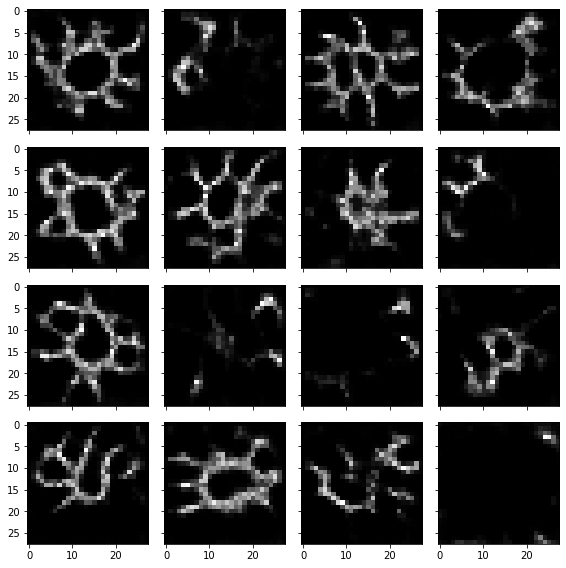

In [94]:
gan.show(shape=(4, 4))

In [ ]:
show()

In [ ]:
gan.save('../models')